In [1]:
#Code to read in variables from the nc files created when grads files are converted using cdo 
#Command is:   cdo -f nc import_binary file.ctl ofile.nc 
#Had to adapt Glen's .ctl files to put distances in meters, even though they're called lat and lon the variables are actually 
# From Glen re the 09_16 files No. The 1 Aug 2008 through 31 July 2009 run assimilates the Mar-Apr 2009 data. My notation has been that I call simulation year 08-09 = 09, 15-16 = 16.

from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
from scipy.io import netcdf
from scipy.spatial import distance
import pyproj
from pyproj import Proj, transform
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
from pylab import savefig
import datetime
import pandas as pd
import glob
import scipy
from scipy.interpolate import griddata
from scipy import stats
import pandas

In [15]:
plt.clf()

In [ ]:
#WARREN COMPARISON
#Get monthly averages using cdo monmean snod_ease_grid.nc monthly_mean_test.nc (worked even over multiple years)

#Get information about the grids using cdo's griddes; here I've got the grid size from the snow model and adapted the Warren grid file to keep lat/lon and just change the resolution
#! cdo griddes /Users/samanthabuzzard/Liston_May_v2/sm_oib_2009-2016/erai/sm_09/snod_ease_grid.nc > myGridDef
#! cdo griddes /Volumes/n4_cpdata/scb/MONTHLY_GRIDS/WARREN/12_WarrenSnowDens.nc > myGridDef
for modelrun in ['09_16']:
    for variable in ['snod', 'sden']:
        for forcing in ['merra', 'erai']:
            if modelrun=='36yrs':
                for year in range (1980,2017,1):
                    if year==1980:
                        for month in range (8,13,1):
                            compare=Compare_With_Warren(forcing,year,month,variable,modelrun)
                    if year==2016:
                        for month in range (1,8,1):
                            compare=Compare_With_Warren(forcing,year,month,variable,modelrun)
                    else:
                        for month in range (1,13,1):
                            compare=Compare_With_Warren(forcing,year,month,variable,modelrun)
            if modelrun=='09_16':
                    for year in range (2009,2015,1):
                        for month in range (1,13,1):
                            compare, x2, y2=Compare_With_Warren(forcing,year,month,variable,modelrun)
                    for month in range (8,13,1):
                        compare=Compare_With_Warren(forcing,'2008',month,variable,modelrun)
                    for month in range (1,8,1):
                        compare=Compare_With_Warren(forcing,'2015',month,variable,modelrun)

In [ ]:
#Buoys comparison

CRREL_buoys=['2013D', '2013A', '2013B', '2013C', '2013E', '2013F', '2013G', '2013H', '2013I', '2014B', '2014C', '2014D', '2014E', '2014I' ]
for buoy in range(0, len(CRREL_buoys), 1):
   # Compare_with_buoy(CRREL_buoys[buoy], 'erai', '09_16', 'CRREL')
   # Compare_with_buoy(CRREL_buoys[buoy], 'merra', '09_16', 'CRREL')
    Compare_with_buoy(CRREL_buoys[buoy], 'erai', '36yrs', 'CRREL')
    Compare_with_buoy(CRREL_buoys[buoy], 'merra', '36yrs', 'CRREL')

# #S1 S6 S7 s8 S9 s10 s11 s12 s14 s15 s16 s17 s21 s24 s25 s29 s31 s33 s37 s40 s46 data corrupt (negative values)
# #S17 S18 S19 S24 'S39','S41','S42','S44','S45','S43','S47','S48','S51','S52','S53' contan no matching points
# #S32 values are way too high test divide by 1000
# AWI_buoys=['S3','S4','S13','S18','S19','S20','S22','S23','S26','S27','S28','S30','S35','S36']
# #AWI_buoys=['S32']
# for buoy in range(0, len(AWI_buoys), 1):
#     Compare_with_buoy(AWI_buoys[buoy], 'erai', '09_16', 'AWI')
#     Compare_with_buoy(AWI_buoys[buoy], 'merra', '09_16', 'AWI')
#     #Compare_with_buoy(AWI_buoys[buoy], 'erai', '36yrs', 'AWI')
#     #Compare_with_buoy(AWI_buoys[buoy], 'merra', '36yrs', 'AWI')
run_buoy_stats_annual()
run_buoys_stats_buoys()

In [ ]:
#OIB 
#Files stored as OIB_all_yyyy_mm_dd.txt have have lon lat snod(m)
#Nearest neighbour comparison didn't work as too many points with similar values so went with binning
#Only keep bins with >100 points as in Petty 2018 eularian snow model evaluation

for modelrun in ['09_16']:
    for year in range(2009,2016,1):
        for forcing in ['erai', 'merra']:
            Compare_OIB(year,forcing,modelrun)

run_OIB_stats()

In [ ]:
#Plot Glen's OIB tracks
#'pcf 'dcf' and 'non' are the three model runs
filepath='/Users/samanthabuzzard/Liston_May_v2/snod_over_OIB_lines/'
plot_oib_tracks(filepath,'merra2','pcf')
plot_oib_tracks(filepath,'erai','pcf')
plot_oib_tracks(filepath,'merra2','dcf')
plot_oib_tracks(filepath,'erai','dcf')
plot_oib_tracks(filepath,'merra2','non')
plot_oib_tracks(filepath,'erai','non')



In [ ]:
#Shalina comparison
#Shalina says usesful for M-A-M

modelruns=['09_16']
forcings=['merra', 'erai']

for modelrun in modelruns:
    for forcing in forcings:
        if modelrun=='09_16':
            for year in range(2009,2016,1):
                for month in range(3,6,1):
                    Compare_Shalina(forcing,year,month,modelrun,'linear')
        if modelrun=='36yrs':
            for year in range(1980,2016,1):
                for month in range(3,6,1):
                    Compare_Shalina(forcing,year,month,modelrun,'linear')

In [3]:
#############FUNCTIONS IN HERE################


######Read in SnowModel nc files 

def Readin_SnowModel_0916(forcing,year,variable):
    """2009 to 2016 yearly files. Variables are 'sden' or 'snod'"""
    yearname='%02d' %(int(str(year)[(len(str(year))-2):]))
    filepath='/Users/samanthabuzzard/Liston_May_v2/sm_oib_2009-2015/'+forcing+'/'+'sm_'+str(yearname)+'/'
    f = Dataset(filepath+variable+'_ease_grid.nc', 'r')
    lon= f.variables['lon'][:]
    lat=f.variables['lat'][:]
    snow=f.variables[variable][:]
    x1, y1=np.meshgrid(lon, lat)
    return snow,x1,y1

def Readin_SnowModel_36(forcing,variable):
    """Have 1st Aug 1980 for 36 years, includes leap years total of 13149 days. Variables are 'sden' or 'snod'"""  
    filepath='/Users/samanthabuzzard/Liston_May_v2/sm_36yrs/'+forcing+'/'
    f = Dataset(filepath+variable+'_ease_grid.nc', 'r')
    lon= f.variables['lon'][:]
    lat=f.variables['lat'][:]
    snow=f.variables[variable][:]
    x1, y1=np.meshgrid(lon, lat)
    return snow,x1,y1

#Get daily data 
def Get_daily_data_0916(snow,year,month,day):
    #Model runs for 365 days regardless of leap year
    #Run is named after the year OIB data is in i.e. sm_09 starts in Aug 2008
    if month in range(1,8,1):
        d0 = datetime.date(year-1, 8, 1)
    else:
        d0 = datetime.date(year, 8, 1)
    d1 = datetime.date(year,month,day)
    delta = d1 - d0
    date=delta.days
    snow_daily=snow[date,:,:]         
    return snow_daily
    
def Get_daily_data_36(snow,year,month,day):
    d0 = datetime.date(1980, 8, 1)
    d1 = datetime.date(year, month, day)
    delta = d1 - d0
    date=delta.days
    snow_daily=snow[date,:,:]
    return snow_daily   

########Warren Comparison

def Compare_With_Warren(forcing,year,month,variable,modelrun):
    #SnowModel data
    yearname='%02d' %(int(str(year)[(len(str(year))-2):]))
    if modelrun=='09_16':
        #First month (i.e. position 0) will be August
        if month in range (1,8,1):
            month_number=month+4
        else:
            month_number=month-8
            yearname='%02d' %(int(str(year)[(len(str(year))-2):])+1)
        snowmodel_filepath='/Users/samanthabuzzard/Liston_May_v2/sm_oib_2009-2015/'+forcing+'/'+'sm_'+str(yearname)+'/'    
    if modelrun=='36yrs':
        snowmodel_filepath='/Users/samanthabuzzard/Liston_May_v2/sm_36yrs/'+forcing+'/'
        month_number=(year-1980)*12+month-8
    f1 = Dataset(snowmodel_filepath+'monthly_mean_'+variable+'.nc', 'r')
    snow_model=f1.variables[variable][month_number,:]
    #Warren data
    monthname='%02d' %(month)
    if variable=='sden':
        variablename='Dens'
    if variable=='snod':
        variablename='Depth'
    warren_filepath='/Volumes/n4_cpdata/scb/MONTHLY_GRIDS/WARREN/'+str(monthname)+'_WarrenSnow'+variablename+'.nc'
    ! ncatted -a long_name,y,m,c,"latitude"  $warren_filepath  #fixes generic variable z unroecognised error: remapbil needs specific variable names
    ! ncatted -a long_name,x,m,c,"longitude"  $warren_filepath
    ! cdo remapbil,myGridDef $warren_filepath temp.nc  
    f2 = Dataset('temp.nc', 'r')
    snow_warren=f2.variables['z'][:]
    
    if modelrun=='36yrs':
    #deal with differences in Glen's nc files
        snow_model=snow_model[0]
        f2 = Dataset('/Users/samanthabuzzard/Liston_May_v2/sm_oib_2009-2015/erai/sm_09/monthly_mean_snod.nc', 'r')
        lon= f2.variables['lon'][:]
        lat= f2.variables['lat'][:]
        x1, y1=np.meshgrid(lon, lat)
    else: 
        lon= f1.variables['lon'][:]
        lat=f1.variables['lat'][:]
        x1, y1=np.meshgrid(lon, lat)
    comp=(snow_model-snow_warren)
    
    Replace6931=pyproj.Proj("+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"); #close to polar stereographic but different latitude of origin/ central meridian so adapted above
    inProj = Proj(init='epsg:3408')#Replace6931  
    outProj = Proj(init='epsg:4326') #lat lon was using 4326
    xx, yy = transform(inProj,outProj,x1,y1)
    m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
    x2,y2=m(xx,yy)
    m.drawparallels(np.arange(60,90,10), linewidth = 0.25, linestyle='solid', zorder=8)
    m.drawmeridians(np.arange(0.,360.,30.), linewidth = 0.25, zorder=8)
    m.drawcoastlines(linewidth=0.5)
    month_numbers=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    if variable == 'sden':
        m.pcolormesh(x2, y2, comp, cmap='RdBu_r', vmin=-200, vmax=200)
        cb = plt.colorbar()
        cb.set_label('Snow density difference ($kgm^{-3}$)')
        plt.title('Snow model monthly average - Warren for '+month_numbers[month-1]+'/'+str(year))
    else:
        m.pcolormesh(x2, y2, comp*100, cmap='RdBu_r', vmin=-40, vmax=40)
        cb = plt.colorbar()
        cb.set_label('Snow depth difference (m)')
        plt.title('Snow model monthly average - Warren for '+month_numbers[month-1]+'/'+str(year))
    m.fillcontinents(color='grey')
    fig_savepath='/Volumes/n4_cpdata/scb/SNOW_DATA/SNOWMODEL_EASE/VALIDATION/WARREN/COMPARISONS_'+modelrun+'/'
    plt.savefig(fig_savepath+'Warrencomparison_'+modelrun+'_'+forcing+str(year)+'_'+str(monthname)+'_'+variable+'.jpeg', dpi=1000)
    plt.show() 
    return comp, x2, y2

########Compare Buoys

def Compare_with_buoy(buoy_name, forcing, modelrun, buoys):
    buoy_lats=[]
    buoy_lons=[]
    buoy_snow=[]
    buoy_year=[]
    buoy_month=[]
    buoy_day=[]
    modelled_snow=[]
    buoy_snow_keep=[]
    buoy_year_keep=[]
    distances=[]
    model_x=[]
    model_y=[]
    month_numbers=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    if buoys=='CRREL':
            Buoy_files=sorted(glob.glob('/Volumes/n4_cpdata/scb/SNOW_DATA/BUOYS/CRREL/SORTED/av_'+buoy_name+'*.txt'))
            figure_path='/Volumes/n4_cpdata/scb/SNOW_DATA/SNOWMODEL_EASE/VALIDATION/BUOYS/CRREL/'
    if buoys=='AWI':
            #AWI files have buoys that cover more than one year- the 20* ensures that e.g. S1 and S10 don't get mixed up
            Buoy_files=sorted(glob.glob('/Volumes/n4_cpdata/scb/SNOW_DATA/BUOYS/AWI/SORTED/av_'+buoy_name+'20*.txt'))
            figure_path='/Volumes/n4_cpdata/scb/SNOW_DATA/SNOWMODEL_EASE/VALIDATION/BUOYS/AWI/'

    if Buoy_files!=[]:
        for item in Buoy_files:
            data=(np.loadtxt(item))
            buoy_lats.append(data[0])
            buoy_lons.append(data[1])
            buoy_snow.append(data[2])
            buoy_year.append(int(item[len(item)-12:len(item)-8]))
            buoy_month.append(item[len(item)-8:len(item)-6])
            buoy_day.append(item[len(item)-6:len(item)-4])

        if modelrun=='36yrs':
            snow, x1, y1=Readin_SnowModel_36(forcing,'snod') #Takes too long to open to do this every time (reopen 09_16 every time as year may change)

        for point in range(0,len(buoy_snow),1):
            if modelrun=='09_16':
                if (int(buoy_year[point])<2008) or (int(buoy_year[point])>2016):
                    continue
                if int(buoy_month[point])>7:
                    snow, x1, y1=Readin_SnowModel_0916(forcing,buoy_year[point],'snod')
                else:
                    snow, x1, y1=Readin_SnowModel_0916(forcing,int(buoy_year[point])-1,'snod')
                snow_model=Get_daily_data_0916(snow,int(buoy_year[point]),int(buoy_month[point]),int(buoy_day[point]))
            if modelrun=='36yrs':
                if (int(buoy_year[point])>2016):
                    continue
                snow_model=Get_daily_data_36(snow,int(buoy_year[point]),int(buoy_month[point]),int(buoy_day[point]))[0]
            if (buoy_lons[point]>180 or buoy_lons[point]<-180 or buoy_lats[point]>90 or buoy_lats[point]<-90):
                print('data invalid for '+str(buoy_name)+' '+str(buoy_day[point])+'/'+str(buoy_month[point])+'/'+str(buoy_year[point]))
                continue
            XX,YY = np.meshgrid(np.arange(snow_model.shape[1]),np.arange(snow_model.shape[0]))
            table = np.vstack((XX.ravel(),YY.ravel())).T
            x2, y2=np.meshgrid(buoy_lons[point], buoy_lats[point])
            outProj = Proj(init='epsg:3408')
            inProj = Proj(init='epsg:4326') #lat lon was using 4326
            #Buoys are transformed to EASE grid 
            xx, yy = transform(inProj,outProj,x2,y2)
            model_grid = list( zip(np.ravel(x1), np.ravel(y1)) ) 
            target_pts = [xx[0][0], yy[0][0]] 
            if (str(target_pts[0])=='nan' or str(target_pts[1])=='nan'):
                continue
            distance, index = scipy.spatial.cKDTree(model_grid).query(target_pts)  #cKDTree is faster than KDTree for simple queries like this
            # the nearest model location (in lat and lon)
            #model_loc_coord = [coord for i, coord in enumerate(model_grid) if i==index]
            nearest_x=table[index][0]
            nearest_y=table[index][1]
            modelled_snow.append(snow_model[nearest_x, nearest_y])
            buoy_snow_keep.append(buoy_snow[point])
            buoy_year_keep.append(buoy_year[point])
            distances.append(distance)
            if distance>25000:
                print('WARNING- comparison point more than 25km away for day '+str(buoy_name)+' '+str(buoy_day[point])+'/'+str(buoy_month[point])+'/'+str(buoy_year[point])+'distance='+str(distance))

            model_x.append(x1[0][nearest_x])
            model_y.append(y1[nearest_y][0])
          
        np.savetxt(figure_path+buoy_name+str(forcing)+'_'+str(modelrun)+'.txt',np.c_[buoy_snow_keep[:],modelled_snow,buoy_year_keep[:]])
            
        plt.plot([i * 1 for i in buoy_snow[:]], label='IMBdepth', color='black') 
        plt.plot(modelled_snow,'--', label='Snow Model depth', color='red')# color=colours[count] if plotting several for one year
        plt.xlabel('Day (starting '+str(buoy_day[0])+' '+month_numbers[int(buoy_month[0])]+' '+str(buoy_year[0])+')')
        plt.ylabel('snow depth (m)')
        plt.title('IMB vs Snow Model '+forcing+': buoy '+buoy_name)
        plt.legend(loc='lower right', bbox_to_anchor=(1.39, 0.785))
        plt.savefig(figure_path+buoy_name+'_'+forcing+'_'+modelrun+".png",dpi=100,bbox_inches='tight')
        plt.show()
        plt.clf()

        m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
        m.drawparallels(np.arange(60,90,10), linewidth = 0.25, linestyle='solid', zorder=8)
        m.drawmeridians(np.arange(0.,360.,30.), linewidth = 0.25, zorder=8)
        m.drawcoastlines(linewidth=0.5)
        x4,y4=m(buoy_lons,buoy_lats)
        m.scatter(x4,y4, s=1, marker='o',color='r')
        Replace6931=pyproj.Proj("+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"); #close to polar stereographic but different latitude of origin/ central meridian so adapted above
        inProj = Proj(init='epsg:3408')#Replace6931  
        outProj = Proj(init='epsg:4326') #lat lon was using 4326
        x3, y3=np.meshgrid(model_x, model_y)
        xx3, yy3 = transform(inProj,outProj,x3,y3)
        xxx3,yyy3=m(xx3,yy3)
        m.scatter(np.ravel(xxx3),np.ravel(yyy3), s=1, marker='o',color='b')
        m.fillcontinents(color='grey')
        plt.savefig(figure_path+buoy_name+'_'+forcing+'_'+modelrun+"_map.png",dpi=100,bbox_inches='tight')
        plt.show() 
        plt.clf()
        
        
#Buoy stats (annual)
def run_buoy_stats_annual():
    years=[]
    forcings=[]
    modelruns=[]
    mean_bias=[]
    RMSE=[]
    mean_bias.append('mean_bias')
    RMSE.append('RMSE')
    years.append('year')
    forcings.append('forcing')
    modelruns.append('model_run')

    for buoys in ['CRREL', 'AWI']:
        filepath='/Volumes/n4_cpdata/scb/SNOW_DATA/SNOWMODEL_EASE/VALIDATION/BUOYS/'+buoys+'/'
        for year in range(2009,2016,1):
            model_snow=[]
            buoy_snow=[]
            for forcing in ['erai','merra']:
                for modelrun in ['09_16','36yrs']:
                    #Probably not the most efficient way but will catch buoys that span multiple years
                    files=sorted(glob.glob(filepath+'*'+str(forcing)+'_'+str(modelrun)+'.txt'))
                    for file in files:
                        data=np.loadtxt(file)
                        for point in range(0,len(data),1): #check len data is this and not 3
                            if int(data[point,2])==year:
                                model_snow.append(data[point,1])
                                buoy_snow.append(data[point,0])
                    if model_snow != []:

                        mean_bias.append(np.nanmean(np.array(model_snow)-np.array(buoy_snow)))
                        RMSE.append(np.nanmean((np.array(model_snow)-np.array(buoy_snow))**2.0)**(1/2.0))
                        years.append(year)
                        forcings.append(forcing)
                        modelruns.append(modelrun)

                        model_snow_hist=np.array(model_snow)
                        buoy_snow_hist=np.array(buoy_snow)

                        bins = np.linspace(0, 1, 21)
                        plt.hist(model_snow_hist[~np.isnan(model_snow_hist)], bins, alpha=0.5, label='modelled snow '+forcing)
                        plt.hist(buoy_snow_hist[~np.isnan(buoy_snow_hist)], bins, alpha=0.5, label='buoy snow')
                        plt.legend(loc='upper right')
                        plt.title('Modelled and buoys snow depths for '+str(year))
                        plt.xlabel('snow depth (m)')
                        plt.savefig(filepath+'Hist_'+str(year)+'_'+forcing+modelrun+'.png')
                        plt.show()
            for modelrun in ['09_16','36yrs']:
                #Probably not the most efficient way but will catch buoys that span multiple years
                model_snow_erai=[]
                model_snow_merra=[]
                buoy_snow=[]
                files=sorted(glob.glob(filepath+'*erai_'+str(modelrun)+'.txt'))
                for file in files:
                    data=np.loadtxt(file)
                    for point in range(0,len(data),1): #check len data is this and not 3
                        if int(data[point,2])==year:
                            model_snow_erai.append(data[point,1])
                            buoy_snow.append(data[point,0])
                files=sorted(glob.glob(filepath+'*merra_'+str(modelrun)+'.txt'))
                for file in files:
                    data=np.loadtxt(file)
                    for point in range(0,len(data),1): #check len data is this and not 3
                        if int(data[point,2])==year:
                            model_snow_merra.append(data[point,1])
                if model_snow_erai != []:

                    model_snow_erai_hist=np.array(model_snow_erai)
                    model_snow_merra_hist=np.array(model_snow_merra)
                    buoy_snow_hist=np.array(buoy_snow)

                    bins = np.linspace(0, 1, 21)
                    plt.hist(model_snow_erai_hist[~np.isnan(model_snow_erai_hist)], bins, alpha=0.5, label='modelled snow (erai)')
                    plt.hist(model_snow_merra_hist[~np.isnan(model_snow_merra_hist)], bins, alpha=0.5, label='modelled snow (merra)')
                    plt.hist(buoy_snow_hist[~np.isnan(buoy_snow_hist)], bins, alpha=0.5, label='buoy snow')
                    plt.legend(loc='upper right')
                    plt.title('Modelled and buoys snow depths for '+str(year))
                    plt.xlabel('snow depth (m)')
                    plt.savefig(filepath+'Hist_'+str(year)+'_bothforcing'+modelrun+'.png')
                    plt.show()

        np.savetxt(filepath+'__stats.txt',np.c_[years, forcings, modelruns, mean_bias, RMSE],fmt='%s')
        
        
#Buoy histograms by buoy

def run_buoy_stats_buoys():

#Buoy histograms by buoy

    CRREL_buoys=['2013D', '2013A', '2013B', '2013C', '2013E', '2013F', '2013G', '2013H', '2013I', '2014B', '2014C', '2014D', '2014E', '2014I' ]
    AWI_buoys=['S3','S4','S13','S18','S19','S20','S22','S23','S26','S27','S28','S30','S35']

    for buoys in ['CRREL', 'AWI']:
        filepath='/Volumes/n4_cpdata/scb/SNOW_DATA/SNOWMODEL_EASE/VALIDATION/BUOYS/'+buoys+'/'
        if buoys=='CRREL':
            for buoy in CRREL_buoys:
                model_snow_erai=[]
                model_snow_merra=[]
                buoy_snow=[]
                data_erai=np.loadtxt(filepath+buoy+'erai_09_16.txt')
                data_merra=np.loadtxt(filepath+buoy+'merra_09_16.txt')
                for point in range(0,len(data_erai),1): #check len data is this and not 3
                    model_snow_erai.append(data_erai[point,1])
                    model_snow_merra.append(data_merra[point,1])
                    buoy_snow.append(data_erai[point,0])
                if model_snow_erai != []:
                    model_snow_hist_erai=np.array(model_snow_erai)
                    model_snow_hist_merra=np.array(model_snow_merra)
                    buoy_snow_hist=np.array(buoy_snow)
                    bins = np.linspace(0, 1, 21)
                    plt.hist(model_snow_hist_erai[~np.isnan(model_snow_hist_erai)], bins, alpha=0.5, label='ERAI modelled snow', color='b')
                    plt.hist(model_snow_hist_merra[~np.isnan(model_snow_hist_merra)], bins, alpha=0.5, label='MERRA2 modelled snow', color='r')
                    plt.hist(buoy_snow_hist[~np.isnan(buoy_snow_hist)], bins, alpha=0.5, label='buoy snow', color='g')
                    plt.legend(loc='upper right')
                    plt.title('Modelled and buoys snow depths for '+str(buoy))
                    plt.xlabel('snow depth (m)')
                    plt.savefig(filepath+'Hist_'+str(buoy)+'_'+modelrun+'.png')
                    plt.show()
        if buoys=='AWI':
            for buoy in AWI_buoys:
                model_snow_erai=[]
                model_snow_merra=[]
                buoy_snow=[]
                data_erai=np.loadtxt(filepath+buoy+'erai_09_16.txt')
                data_merra=np.loadtxt(filepath+buoy+'merra_09_16.txt')
                for point in range(0,len(data_erai),1): #check len data is this and not 3
                    model_snow_erai.append(data_erai[point,1])
                    model_snow_merra.append(data_merra[point,1])
                    buoy_snow.append(data_erai[point,0])
                if model_snow_erai != []:
                    model_snow_hist_erai=np.array(model_snow_erai)
                    model_snow_hist_merra=np.array(model_snow_merra)
                    buoy_snow_hist=np.array(buoy_snow)
                    bins = np.linspace(0, 1, 21)
                    plt.hist(model_snow_hist_erai[~np.isnan(model_snow_hist_erai)], bins, alpha=0.5, label='ERAI modelled snow', color='b')
                    plt.hist(model_snow_hist_merra[~np.isnan(model_snow_hist_merra)], bins, alpha=0.5, label='MERRA2 modelled snow', color='r')
                    plt.hist(buoy_snow_hist[~np.isnan(buoy_snow_hist)], bins, alpha=0.5, label='buoy snow', color='g')
                    plt.legend(loc='upper right')
                    plt.title('Modelled and buoys snow depths for '+str(buoy))
                    plt.xlabel('snow depth (m)')
                    plt.savefig(filepath+'Hist_'+str(buoy)+'_'+modelrun+'.png')
                    plt.show()
    
########Compare OIB

def Compare_OIB(year,forcing,modelrun):
    OIB_lats=[]
    OIB_lons=[]
    OIB_snow=[]
    OIB_month=[]
    OIB_day=[]
    modelled_snow=[]
    model_x=[]
    model_y=[]
    OIB_snow_keep=[]
    model_snow_keep=[]
    diff_keep=[]
    lats_keep=[]
    lons_keep=[]

    if modelrun=='09_16':
        snow,x1,y1=Readin_SnowModel_0916(forcing,year,'snod')
    if modelrun=='36yrs':
        snow,x1,y1=Readin_SnowModel_36(forcing,'snod')


    OIB_files=sorted(glob.glob('/Volumes/n4_cpdata/scb/SNOW_DATA/LISTON_v2/VALIDATION/OIB/DAILY_FILES/OIB_all_'+str(year)+'*.txt'))
    for item in OIB_files:
        data=(np.loadtxt(item))
        if data!=[]:
            for point in range(0,len(data),1):
                OIB_lons.append(data[point][0])
                OIB_lats.append(data[point][1])
                OIB_snow.append(data[point][2])
                OIB_month.append(item[len(item)-9:len(item)-7])
                OIB_day.append(item[len(item)-6:len(item)-4])

            Replace6931=pyproj.Proj("+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"); #close to polar stereographic but different latitude of origin/ central meridian so adapted above
            outProj = Proj(init='epsg:3408')#Replace6931  
            inProj = Proj(init='epsg:4326') #lat lon was using 4326
            xx, yy = transform(inProj,outProj,OIB_lons,OIB_lats)

            for month in range(3,5,1):
                for day in range(1,32,1):
                    daily_snow=[]
                    daily_lons=[]
                    daily_lats=[]
                    for point in range(0,len(data),1):
                        if (int(OIB_month[point])==month) and (int(OIB_day[point])==day):
                            daily_snow.append(OIB_snow[point])
                            daily_lons.append(xx[point])
                            daily_lats.append(yy[point])
                    if daily_snow!=[]:
                        if modelrun=='09_16':
                            daily_model_snow=Get_daily_data_0916(snow,year,month,day)
                        if modelrun=='36yrs':
                            daily_model_snow=Get_daily_data_36(snow,year,month,day)
                        x_bins=np.arange(-4525000, 4500001, 25000)#have to make end point slightly over final value wanted because... python
                        y_bins=np.arange(-4525000, 4500001, 25000)#bins also have to start 1 before grid to create 361x361
                        #Works like histogram- y values come first
                        H2D = stats.binned_statistic_2d(daily_lats, daily_lons, daily_snow, statistic='mean',bins=[x_bins,y_bins])
                        count = stats.binned_statistic_2d(daily_lats, daily_lons, daily_snow, statistic='count',bins=[x_bins,y_bins])

                        for a in range(0,(len(H2D[1])-1),1):
                            for b in range(0,(len(H2D[2])-1),1):
                                if count[0][a,b]>100:
                                    OIB_snow_keep.append(H2D[0][a,b])
                                    model_snow_keep.append(daily_model_snow[a,b])
                                    diff_keep.append(daily_model_snow[a,b]-H2D[0][a,b])
                                    lats_keep.append(H2D[1][a])
                                    lons_keep.append(H2D[2][b])

    savepath='/Volumes/n4_cpdata/scb/SNOW_DATA/SNOWMODEL_EASE/VALIDATION/OIB/BINNED/'

    np.savetxt(savepath+str(year)+str(forcing)+str(modelrun)+'.txt',np.c_[model_snow_keep,OIB_snow_keep])


    m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')


    #Plot OIB track over April average for given year
    x_bins=np.arange(-180, 180.0000001, (360-1/12)/360)
    y_bins=np.arange((30-1/6), 90.000001, 60/360)
    H2D_all = stats.binned_statistic_2d(OIB_lats, OIB_lons, OIB_snow, statistic='mean',bins=[y_bins,x_bins])
    x3,y3=np.meshgrid(H2D_all[2],H2D_all[1])
    x2,y2=m(x3,y3)
    m.drawparallels(np.arange(60,90,10), linewidth = 0.25, linestyle='solid', zorder=8)
    m.drawmeridians(np.arange(0.,360.,30.), linewidth = 0.25, zorder=8)
    m.drawcoastlines(linewidth=0.5)

    if modelrun=='09_16':
            snowmodel_filepath='/Users/samanthabuzzard/Liston_May_v2/sm_oib_2009-2015/'+forcing+'/'+'sm_'+str(year)[2:4]+'/'    
            #First month (i.e. position 0) will be August
            if month in range (1,8,1):
                month_number=month+4
            else:
                month_number=month-8
    if modelrun=='36yrs':
            snowmodel_filepath='/Users/samanthabuzzard/Liston_May_v2/sm_36yrs/'+forcing+'/'
            month_number=(year-1980)*12+month-8
    f1 = Dataset(snowmodel_filepath+'monthly_mean_'+'snod'+'.nc', 'r')
    snow_model=f1.variables['snod'][month_number,:]
    Replace6931=pyproj.Proj("+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"); #close to polar stereographic but different latitude of origin/ central meridian so adapted above
    inProj = Proj(init='epsg:3408')#Replace6931  
    outProj = Proj(init='epsg:4326') #lat lon was using 4326
    xx, yy = transform(inProj,outProj,x1,y1)
    m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
    x4,y4=m(xx,yy)
    m.pcolormesh(x4,y4,snow_model,cmap='coolwarm', vmin=-0.5, vmax=0.5)
    cb = plt.colorbar()
    m.pcolormesh(x2, y2,(H2D_all[0]), cmap='Blues', vmin=-0.5, vmax=0.5)
    cb = plt.colorbar()
    cb.set_label('Snow depth (m)')
    plt.title('Snowmodel (Apr average) and OIB tracks for '+str(year))
    plt.savefig(savepath+str(year)+str(forcing)+str(modelrun)+'map.png')
    plt.show()

    #Scatterplot of results
    plt.clf()
    plt.scatter(OIB_snow_keep,model_snow_keep)
    plt.title('Snowmodel vs OIB snow depths for '+str(year))
    plt.xlabel('OIB snow depth (m)')
    plt.ylabel('Snow model snow depth (m)')
    plt.savefig(savepath+str(year)+str(forcing)+str(modelrun)+'scatter.png')
    plt.show()
    
    #Plot difference between results
    plt.clf()
    m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
    Replace6931=pyproj.Proj("+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"); #close to polar stereographic but different latitude of origin/ central meridian so adapted above
    inProj = Proj(init='epsg:3408')#Replace6931  
    outProj = Proj(init='epsg:4326') #lat lon was using 4326
    xx, yy = transform(inProj,outProj,lons_keep, lats_keep)
    x2,y2=m(xx,yy)
    m.drawparallels(np.arange(60,90,10), linewidth = 0.25, linestyle='solid', zorder=8)
    m.drawmeridians(np.arange(0.,360.,30.), linewidth = 0.25, zorder=8)
    m.drawcoastlines(linewidth=0.5)
    m.scatter(np.array(x2),np.array(y2),c=diff_keep,cmap='viridis',s=5,vmin=-0.5, vmax=0.5)
    plt.title('Difference between snow model and OIB for '+str(year)+' '+forcing)
    m.fillcontinents(color='grey')
    cb = plt.colorbar()
    cb.set_label('Snow depth difference (m)')
    plt.savefig(savepath+str(year)+str(forcing)+str(modelrun)+'differencemap.png')
    plt.show()
    
#OIB stats

def run_OIB_stats():

    years=[]
    forcings=[]
    modelruns=[]
    mean_bias=[]
    RMSE=[]
    mean_bias.append('mean_bias')
    RMSE.append('RMSE')
    years.append('year')
    forcings.append('forcing')
    modelruns.append('model_run')

    filepath='/Volumes/n4_cpdata/scb/SNOW_DATA/SNOWMODEL_EASE/VALIDATION/OIB/BINNED/'
    for year in range(2009,2016,1):
        for forcing in ['erai','merra']:
            for modelrun in ['09_16']:
                file=filepath+str(year)+forcing+modelrun+'.txt'
                data=np.loadtxt(file)
                model_snow=data[:,0]
                OIB_snow=data[:,1]
                mean_bias.append(np.nanmean(model_snow-OIB_snow))
                RMSE.append(np.nanmean((model_snow-OIB_snow)**2.0))**(1/2.0)
                years.append(year)
                forcings.append(forcing)
                modelruns.append(modelrun)
    np.savetxt(filepath+'_stats.txt',np.c_[years, forcings, modelruns, mean_bias, RMSE],fmt='%s')
    
    
#OIB tracks using Glen's files

def plot_oib_tracks(file, forcing, model_type): 
    f1 = Dataset(file+'snod_'+forcing+'_oib_years.nc', 'r')
    model_snow=f1.variables['snod_'+model_type]
    oib_snow=f1.variables['snod_oib']
    #lon=f1.variables['lon']
    #lat=f1.variables['lat']
    snow,lon,lat=Readin_SnowModel_0916('erai',2010,'snod') #don't need the snow, just to get the grid
    if model_type=='pcf':
        model_description='with precip correction'
    elif model_type=='dcf':
        model_description='with precip and density correction'
    else:
        model_description='without any corrections'
        
    for year in range(2009, 2017, 1):
        year_number=year-2009
        difference=model_snow[year_number]-oib_snow[year_number]#old files had a 4th dim so needed oib_snow[year_number][0]
        plt.clf()
        m = Basemap(projection='npstere',boundinglat=70,lon_0=0,resolution='l')
        Replace6931=pyproj.Proj("+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"); #close to polar stereographic but different latitude of origin/ central meridian so adapted above
        inProj = Proj(init='epsg:3408')#Replace6931  
        outProj = Proj(init='epsg:4326') #lat lon was using 4326
        #x, y=np.meshgrid(lon,lat)
        x1, y1 = transform(inProj,outProj,lon, lat)#new files not on a normal grid
        x2,y2=m(x1,y1)
        m.drawparallels(np.arange(60,90,10), linewidth = 0.25, linestyle='solid', zorder=8)
        m.drawmeridians(np.arange(0.,360.,30.), linewidth = 0.25, zorder=8)
        m.drawcoastlines(linewidth=0.5)
        m.scatter(np.array(x2),np.array(y2),c=difference,cmap='viridis',s=8,vmin=-0.25, vmax=0.25)
        plt.title('Snow model ('+model_description+')- OIB for '+str(year)+' '+forcing)
        m.fillcontinents(color='grey')
        cb = plt.colorbar()
        cb.set_label('Snow depth difference (m)')
        plt.savefig('/Volumes/n4_cpdata/scb/SNOW_DATA/SNOWMODEL_EASE/VALIDATION/OIB/LISTON/'+file[62:(len(file)-3)]+str(year)+str(forcing)+'_'+str(model_type)+'_differencemap.png')
        plt.show()


#############Shalina

def Read_in_Shalina(grid_x,grid_y,interp_method):

    df = pandas.read_excel('/Volumes/FREECOMHDD/SNOW_DATA/SHALINA/grid_data.xlsx')
    #print the column names
    print (df.columns)
    #get the values for a given column
    X = df['X'].values #in polar stereographic
    Y = df['Y'].values
    snow = df['snow depth in cm'].values #in cm
    inProj=pyproj.Proj("+proj=laea +lat_0=90 +lon_0=20 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs");
    #close to polar stereographic but different latitude of origin/ central meridian so adapted above 
    outProj = Proj(init='epsg:4326') #lat lon
    xx, yy = transform(inProj,outProj, X, Y)

    ##Test grids are in same domain
    #plt.scatter(x2,y2)
    #plt.hold('True')
    #plt.scatter(x1,y1)
    #plt.show()
    
    #Code to define a grid- not used here but useful to keep
    #grid_x, grid_y=np.mgrid[(-180+(1/12)):180:361j, 30:90:361j]#j means the final value is included


    m = Basemap(projection='npstere',boundinglat=60,lon_0=0, resolution='l')
    x1,y1=m(xx,yy)
    snow2=griddata((x1,y1), snow, (grid_x,grid_y), method=interp_method)
    
    ##PLOT 
    #m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
    #m.drawparallels(np.arange(60,90,10), linewidth = 0.25, linestyle='solid', zorder=8)
    #m.drawmeridians(np.arange(0.,360.,30.), linewidth = 0.25, zorder=8)
    #m.drawcoastlines(linewidth=0.5)
    #m.pcolormesh(x2, y2, snow2_linear, cmap='RdBu_r')
    #m.fillcontinents(color='grey')
    ##plt.axis([lon.min(), lon.max(), lat.min(), lat.max()]) #messes things up when there are nans!
    #cb = plt.colorbar()
    #cb.set_label('Snow depth difference (m)')
    #plt.show() 
    return snow2

def Compare_Shalina(forcing,year,month,modelrun,interp_method):
    #Compare with monthly snow model data
    yearname='%02d' %(int(str(year)[(len(str(year))-2):]))
    if modelrun=='09_16':
        snowmodel_filepath='/Users/samanthabuzzard/Liston_May_v2/sm_oib_2009-2015/'+forcing+'/'+'sm_'+str(yearname)+'/'
        f1 = Dataset(snowmodel_filepath+'monthly_mean_snod.nc', 'r')
        #First month (i.e. position 0) will be August
        if month in range (1,8,1):
            month_number=month+4
        else:
            month_number=month-8
    if modelrun=='36yrs':
        snowmodel_filepath='/Users/samanthabuzzard/Liston_May_v2/sm_36yrs/'+forcing+'/'
        f1 = Dataset(snowmodel_filepath+'monthly_mean_snod.nc', 'r')
        month_number=(year-1980)*12+month-8
    snow_model=f1.variables['snod'][month_number,:]
    lon= f1.variables['lon'][:]
    lat=f1.variables['lat'][:]
    x1, y1=np.meshgrid(lon, lat)
    Replace6931=pyproj.Proj("+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"); #close to polar stereographic but different latitude of origin/ central meridian so adapted above
    inProj = Proj(init='epsg:3408')#Replace6931  
    outProj = Proj(init='epsg:4326') #lat lon was using 4326
    xx, yy = transform(inProj,outProj,x1,y1)
    m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
    x2,y2=m(xx,yy) 
    #Shalina data
    sh_snow=Read_in_Shalina(x2,y2,interp_method)
    m.drawparallels(np.arange(60,90,10), linewidth = 0.25, linestyle='solid', zorder=8)
    m.drawmeridians(np.arange(0.,360.,30.), linewidth = 0.25, zorder=8)
    m.drawcoastlines(linewidth=0.5)
    month_numbers=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    comp=snow_model-sh_snow/100
    m.pcolormesh(x2, y2, comp*100, cmap='RdBu_r', vmin=-40, vmax=40)
    cb = plt.colorbar()
    cb.set_label('Snow depth difference (m)')
    plt.title('Snow model monthly average ('+forcing+')- Shalina for '+month_numbers[month-1]+' '+str(year))
    m.fillcontinents(color='grey')
    fig_savepath='/Volumes/n4_cpdata/scb/SNOW_DATA/SNOWMODEL_EASE/VALIDATION/SHALINA/'
    monthname='%02d' %(month)
    plt.savefig(fig_savepath+'Shalinacomparison_09_16_'+forcing+str(year)+'_'+str(monthname)+'.jpeg', dpi=1000)
    plt.show() 
    return comp, xx, yy




In [102]:
plt.clf()

In [ ]:
#Sheba comparison

#annual
savepath='/Volumes/n4_cpdata/scb/SNOW_DATA/SNOWMODEL_EASE/VALIDATION/SHEBA/'
mean_bias=[]
RMSE=[]
forcing=[]
sheba=[]
merra=[]
erai=[]
month=[]
day=[]
year=[]
mean_bias.append('mean bias')
RMSE.append('RMSE')
forcing.append('forcing')
df = pandas.read_csv(savepath+'snow_depths.dat')
for point in range (0, len(df),1):
    if (float(df.iloc[point][0][55:62])<1000 and float(df.iloc[point][0][68:75])<1000): #Some odd data values in file
        month.append(str(df.iloc[point][0])[10:12])
        day.append(str(df.iloc[point][0])[22:24])
        year.append(str(df.iloc[point][0])[32:36])
        sheba.append(float(df.iloc[point][0][42:49]))
        merra.append(float(df.iloc[point][0][55:62]))
        erai.append(float(df.iloc[point][0][68:75]))
    
model_snow_erai_hist=np.array(erai)
model_snow_merra_hist=np.array(merra)
sheba_snow_hist=np.array(sheba)
mean_bias.append(np.nanmean(np.array(erai)-np.array(sheba)))
RMSE.append(np.nanmean((np.array(erai)-np.array(sheba))**2.0)**(1/2.0))
forcing.append('erai')
mean_bias.append(np.nanmean(np.array(merra)-np.array(sheba)))
RMSE.append(np.nanmean((np.array(merra)-np.array(sheba))**2.0)**(1/2.0))
forcing.append('merra')

bins = np.linspace(0, 20, 21)
plt.hist(model_snow_erai_hist[~np.isnan(model_snow_erai_hist)], bins, alpha=0.5, label='modelled snow (erai)')
plt.hist(model_snow_merra_hist[~np.isnan(model_snow_merra_hist)], bins, alpha=0.5, label='modelled snow (merra)')
plt.hist(sheba_snow_hist[~np.isnan(sheba_snow_hist)], bins, alpha=0.5, label='sheba snow')
plt.legend(loc='upper right')
plt.title('Modelled and sheba snow depths')
plt.xlabel('snow depth (m)')
plt.savefig(savepath+'Hist_sheba.jpeg')
plt.show()

np.savetxt(savepath+'__stats.txt',np.c_[forcing, mean_bias, RMSE],fmt='%s')


#monthly

month_names=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
mean_bias=[]
RMSE=[]
forcing=[]
months=[]
mean_bias.append('mean bias')
RMSE.append('RMSE')
forcing.append('forcing')
months.append('month')
df = pandas.read_csv(savepath+'snow_depths.dat')

for month_number in range (1,13,1):
    sheba=[]
    merra=[]
    erai=[]
    month=[]
    day=[]
    year=[]
    for point in range (0, len(df),1):
        if int(str(df.iloc[point][0])[10:12])==month_number:
            if (float(df.iloc[point][0][55:62])<1000 and float(df.iloc[point][0][68:75])<1000): #Some odd data values in file
                month.append(str(df.iloc[point][0])[10:12])
                day.append(str(df.iloc[point][0])[22:24])
                year.append(str(df.iloc[point][0])[32:36])
                sheba.append(float(df.iloc[point][0][42:49]))
                merra.append(float(df.iloc[point][0][55:62]))
                erai.append(float(df.iloc[point][0][68:75]))

    model_snow_erai_hist=np.array(erai)
    model_snow_merra_hist=np.array(merra)
    sheba_snow_hist=np.array(sheba)
    mean_bias.append(np.nanmean(np.array(erai)-np.array(sheba)))
    RMSE.append(np.nanmean((np.array(erai)-np.array(sheba))**2.0)**(1/2.0))
    forcing.append('erai')
    months.append(month_names[month_number-1])
    mean_bias.append(np.nanmean(np.array(merra)-np.array(sheba)))
    RMSE.append(np.nanmean((np.array(merra)-np.array(sheba))**2.0)**(1/2.0))
    forcing.append('merra')
    months.append(month_names[month_number-1])

    bins = np.linspace(0, 20, 21)
    plt.hist(model_snow_erai_hist[~np.isnan(model_snow_erai_hist)], bins, alpha=0.5, label='modelled snow (erai)')
    plt.hist(model_snow_merra_hist[~np.isnan(model_snow_merra_hist)], bins, alpha=0.5, label='modelled snow (merra)')
    plt.hist(sheba_snow_hist[~np.isnan(sheba_snow_hist)], bins, alpha=0.5, label='sheba snow')
    plt.legend(loc='upper right')
    plt.title('Modelled and sheba snow depths for '+month_names[month_number-1])
    plt.xlabel('snow depth (m)')
    plt.savefig(savepath+'Hist_sheba_'+str(month_number)+'.jpeg')
    plt.show()

np.savetxt(savepath+'__stats_months.txt',np.c_[forcing, months, mean_bias, RMSE],fmt='%s')





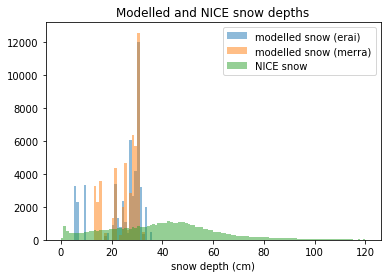

In [30]:
savepath='/Volumes/n4_cpdata/scb/SNOW_DATA/SNOWMODEL_EASE/VALIDATION/NICE/'
erai=np.loadtxt(savepath+'nice_comparison_erai09_16.txt')
merra=np.loadtxt(savepath+'nice_comparison_merra09_16.txt')
erai_snow=erai[:,2]*100
merra_snow=merra[:,2]*100
nice_snow=erai[:,3]*100
model_snow_erai_hist=np.array(erai_snow)
model_snow_merra_hist=np.array(merra_snow)
sheba_snow_hist=np.array(nice_snow)

bins = np.linspace(0, 120, 121)
plt.hist(model_snow_erai_hist[~np.isnan(model_snow_erai_hist)], bins, alpha=0.5, label='modelled snow (erai)')
plt.hist(model_snow_merra_hist[~np.isnan(model_snow_merra_hist)], bins, alpha=0.5, label='modelled snow (merra)')
plt.hist(sheba_snow_hist[~np.isnan(sheba_snow_hist)], bins, alpha=0.5, label='NICE snow')
plt.legend(loc='upper right')
plt.title('Modelled and NICE snow depths')
plt.xlabel('snow depth (cm)')
plt.savefig(savepath+'Hist_NICE.jpeg')
plt.show()

In [ ]:
#This should work but need older data to compare to- run when have Glen's files

forcing='erai'
modelrun='09_16'
savepath='/Volumes/n4_cpdata/scb/SNOW_DATA/SNOWMODEL_EASE/VALIDATION/SUMUP/'
mean_bias=[]
RMSE=[]
modelled_snow=[]
sumup_snow=[]
lats_keep=[]
lons_keep=[]
for point in range (0, len(df),1):
    year=str(df.iloc[point][0])[0:4]
    if int(year) >= 2009 and int(year) <= 2015:
        snow,x1,y1=Readin_SnowModel_0916(forcing,year,'snod')
        month=str(df.iloc[point][0])[4:6]
        day=str(df.iloc[point][0])[6:8]
        lat=df.iloc[point][1]
        lon=df.iloc[point][2]
        snod=df.iloc[point][4]
        snod_error=df.iloc[point][5]
        snow_model=Get_daily_data_0916(snow,int(year),int(month),int(day))
        
        XX,YY = np.meshgrid(np.arange(snow_model.shape[1]),np.arange(snow_model.shape[0]))
        table = np.vstack((XX.ravel(),YY.ravel())).T
        x2, y2=np.meshgrid(lat, lon)
        outProj = Proj(init='epsg:3408')
        inProj = Proj(init='epsg:4326') #lat lon was using 4326
        #Sumup points are transformed to EASE grid 
        xx, yy = transform(inProj,outProj,x2,y2)
        model_grid = list( zip(np.ravel(x1), np.ravel(y1)) ) 
        target_pts = [xx[0][0], yy[0][0]] 
        if (str(target_pts[0])=='nan' or str(target_pts[1])=='nan'):
            continue
        distance, index = scipy.spatial.cKDTree(model_grid).query(target_pts)  #cKDTree is faster than KDTree for simple queries like this
        print(distance)
        # the nearest model location (in lat and lon)
        #model_loc_coord = [coord for i, coord in enumerate(model_grid) if i==index]
        nearest_x=table[index][0]
        nearest_y=table[index][1]
        modelled_snow.append(snow_model[nearest_x, nearest_y])
        sumup_snow.append(snod)
        lats_keep.append(lat)
        lons_keep.append(lon)

mean_bias.append(np.nanmean(np.array(modelled_snow)-np.array(sumup_snow)))
RMSE.append(np.nanmean((np.array(modelled_snow)-np.array(sumup_snow))**2.0)**(1/2.0))


#Scatterplot of results
plt.clf()
plt.scatter(sumup_snow,modelled_snow)
plt.title('Snowmodel ('+forcing+') vs SUMUP snow depths')
plt.xlabel('SUMUP snow depth (m)')
plt.ylabel('Snow model snow depth (m)')
plt.savefig(savepath+'sumup_comparison_'+str(forcing)+str(modelrun)+'scatter.png')
plt.show()

np.savetxt(filepath+'_stats.txt',np.c_[years, forcings, modelruns, mean_bias, RMSE],fmt='%s')





In [ ]:
#Gridded version
#N-ICE data and code to make it in n4_cpdata/scb/SNOW_DATA/NPOLAR/ReadN_ICE.ipynb
mean_bias=[]
RMSE=[]

for forcing in ['erai','merra']:

    modelrun='09_16'
    year=2015

    savepath='/Volumes/n4_cpdata/scb/SNOW_DATA/SNOWMODEL_EASE/VALIDATION/NICE/'


    if modelrun=='09_16':
        snow,x1,y1=Readin_SnowModel_0916(forcing,year,'snod')
    if modelrun=='36yrs':
        snow,x1,y1=Readin_SnowModel_36(forcing,'snod')
    data=(np.loadtxt('/Volumes/n4_cpdata/scb/SNOW_DATA/NPOLAR/Read_in_magna/all_data.txt'))
    year=data[:,0]
    month=data[:,1]
    day=data[:,2]
    lats=data[:,3]
    lons=data[:,4]
    nice_snow=data[:,5]
    modelled_snow=[]

    nice_snow_keep=[]
    lats_keep=[]
    lons_keep=[]


     for point in range(0,len(data),1):
                OIB_lons.append(data[point][0])
                OIB_lats.append(data[point][1])
                OIB_snow.append(data[point][2])
                OIB_month.append(item[len(item)-9:len(item)-7])
                OIB_day.append(item[len(item)-6:len(item)-4])

            Replace6931=pyproj.Proj("+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"); #close to polar stereographic but different latitude of origin/ central meridian so adapted above
            outProj = Proj(init='epsg:3408')#Replace6931  
            inProj = Proj(init='epsg:4326') #lat lon was using 4326
            xx, yy = transform(inProj,outProj,OIB_lons,OIB_lats)

            for month in range(3,5,1):
                for day in range(1,32,1):
                    daily_snow=[]
                    daily_lons=[]
                    daily_lats=[]
                    for point in range(0,len(data),1):
                        if (int(OIB_month[point])==month) and (int(OIB_day[point])==day):
                            daily_snow.append(OIB_snow[point])
                            daily_lons.append(xx[point])
                            daily_lats.append(yy[point])
                    if daily_snow!=[]:
                        if modelrun=='09_16':
                            daily_model_snow=Get_daily_data_0916(snow,year,month,day)
                        if modelrun=='36yrs':
                            daily_model_snow=Get_daily_data_36(snow,year,month,day)
                        x_bins=np.arange(-4525000, 4500001, 25000)#have to make end point slightly over final value wanted because... python
                        y_bins=np.arange(-4525000, 4500001, 25000)#bins also have to start 1 before grid to create 361x361
                        #Works like histogram- y values come first
                        H2D = stats.binned_statistic_2d(daily_lats, daily_lons, daily_snow, statistic='mean',bins=[x_bins,y_bins])
                        count = stats.binned_statistic_2d(daily_lats, daily_lons, daily_snow, statistic='count',bins=[x_bins,y_bins])

                        for a in range(0,(len(H2D[1])-1),1):
                            for b in range(0,(len(H2D[2])-1),1):
                                if count[0][a,b]>100:
                                    OIB_snow_keep.append(H2D[0][a,b])
                                    model_snow_keep.append(daily_model_snow[a,b])
                                    diff_keep.append(daily_model_snow[a,b]-H2D[0][a,b])
                                    lats_keep.append(H2D[1][a])
                                    lons_keep.append(H2D[2][b])

    savepath='/Volumes/n4_cpdata/scb/SNOW_DATA/SNOWMODEL_EASE/VALIDATION/OIB/BINNED/'
    
    np.savetxt(savepath+'nice_comparison_'+str(forcing)+str(modelrun)+'.txt',np.c_[lats_keep, lons_keep, modelled_snow, nice_snow_keep])
       

    mean_bias.append(np.nanmean(np.array(modelled_snow)-np.array(nice_snow_keep)))
    RMSE.append(np.nanmean((np.array(modelled_snow)-np.array(nice_snow_keep))**2.0)**(1/2.0))

    #Scatterplot of results
    plt.clf()
    plt.scatter(nice_snow_keep,modelled_snow)
    plt.title('Snowmodel ('+forcing+') vs N-ICE snow depths')
    plt.xlabel('N-ICE snow depth (m)')
    plt.ylabel('Snow model snow depth (m)')
    plt.savefig(savepath+'nice_comparison_'+str(forcing)+str(modelrun)+'scatter.png')
    plt.show()




In [ ]:
#N-ICE data and code to make it in n4_cpdata/scb/SNOW_DATA/NPOLAR/ReadN_ICE.ipynb
mean_bias=[]
RMSE=[]

for forcing in ['erai','merra']:

    modelrun='09_16'
    year=2015

    savepath='/Volumes/n4_cpdata/scb/SNOW_DATA/SNOWMODEL_EASE/VALIDATION/NICE/'


    if modelrun=='09_16':
        snow,x1,y1=Readin_SnowModel_0916(forcing,year,'snod')
    if modelrun=='36yrs':
        snow,x1,y1=Readin_SnowModel_36(forcing,'snod')
    data=(np.loadtxt('/Volumes/n4_cpdata/scb/SNOW_DATA/NPOLAR/Read_in_magna/all_data.txt'))
    year=data[:,0]
    month=data[:,1]
    day=data[:,2]
    lats=data[:,3]
    lons=data[:,4]
    nice_snow=data[:,5]
    modelled_snow=[]

    nice_snow_keep=[]
    lats_keep=[]
    lons_keep=[]


    for point in range (0, len(nice_snow),1):
                if modelrun=='09_16':
                    snow_model=Get_daily_data_0916(snow,int(year[point]),int(month[point]),int(day[point]))
                if modelrun=='36yrs':
                    snow_model=Get_daily_data_36(snow,int(year[point]),int(month[point]),int(day[point]))
                XX,YY = np.meshgrid(np.arange(snow_model.shape[1]),np.arange(snow_model.shape[0]))
                table = np.vstack((XX.ravel(),YY.ravel())).T
                x2, y2=np.meshgrid(lons[point], lats[point])
                outProj = Proj(init='epsg:3408')
                inProj = Proj(init='epsg:4326') #lat lon was using 4326
                #N-ICE points are transformed to EASE grid 
                xx, yy = transform(inProj,outProj,x2,y2)
                model_grid = list( zip(np.ravel(x1), np.ravel(y1)) ) 
                target_pts = [xx[0][0], yy[0][0]] 
                if (str(target_pts[0])=='nan' or str(target_pts[1])=='nan'):
                    continue
                distance, index = scipy.spatial.cKDTree(model_grid).query(target_pts)  #cKDTree is faster than KDTree for simple queries like this
                distance
                # the nearest model location (in lat and lon)
                #model_loc_coord = [coord for i, coord in enumerate(model_grid) if i==index]
                nearest_x=table[index][0]
                nearest_y=table[index][1]
                modelled_snow.append(snow_model[nearest_x, nearest_y])
                nice_snow_keep.append(nice_snow[point])
                lats_keep.append(lats[point])
                lons_keep.append(lons[point])
    
    
    np.savetxt(savepath+'nice_comparison_'+str(forcing)+str(modelrun)+'.txt',np.c_[lats_keep, lons_keep, modelled_snow, nice_snow_keep])
       

    mean_bias.append(np.nanmean(np.array(modelled_snow)-np.array(nice_snow_keep)))
    RMSE.append(np.nanmean((np.array(modelled_snow)-np.array(nice_snow_keep))**2.0)**(1/2.0))

    #Scatterplot of results
    plt.clf()
    plt.scatter(nice_snow_keep,modelled_snow)
    plt.title('Snowmodel ('+forcing+') vs N-ICE snow depths')
    plt.xlabel('N-ICE snow depth (m)')
    plt.ylabel('Snow model snow depth (m)')
    plt.savefig(savepath+'nice_comparison_'+str(forcing)+str(modelrun)+'scatter.png')
    plt.show()



In [ ]:
#WARREN/ SHALINA COMPARISON- Comparison with JS's monthly means for the 36 year files

def Readin_SnowModel_0916_temp(forcing,year,variable):
    """2009 to 2016 yearly files. Variables are 'sden' or 'snod'"""
    yearname='%02d' %(int(str(year)[(len(str(year))-2):]))
    filepath='/Volumes/FREECOMHDD/SnowModel/MODEL_FILES/'+'sm_'+str(yearname)+'/'
    f = Dataset(filepath+variable+'_ease_grid.nc', 'r')
    lon= f.variables['lon'][:]
    lat=f.variables['lat'][:]
    snow=f.variables[variable][:]
    x1, y1=np.meshgrid(lon, lat)
    return snow,x1,y1

def Compare_With_Warren_36(forcing,year,month,variable,modelrun):
    #SnowModel data
    not_needed, x1, y1=Readin_SnowModel_0916_temp('erai',2010,'snod')#date doesn't matter it's just to get the grid
    month_numbers=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    if modelrun=='36yrs':
        snowmodel_filepath='/Volumes/FREECOMHDD/SnowModel/MONTHLY_MEANS/'+forcing+'_'+variable+'_'+month_numbers[int(month)-1]+'_'+str(year)+'.img'
        dimT= 1
        dimX = 361 #number of rows
        dimY = 361 #number of columns
        with open(snowmodel_filepath, 'rb') as fr:
            hdr = fr.read(0)#changed from 300 assuming js files have no header
            ice = np.fromfile(fr, dtype=np.float32)#Will's nsidc conc data needed uint32 (or 8, 16 etc)
            ice = ice.reshape(dimT,dimY,dimX)
            ice = np.fliplr(ice)#Flips data l-r (Will's nsidc conc data needed flipud)
            snow_model = ice/100

    #Warren data
    monthname='%02d' %(month)
    if variable=='sden':
        variablename='Dens'
    if variable=='snod':
        variablename='Depth'
    warren_filepath='/Volumes/FREECOMHDD/MONTHLY_GRIDS/WARREN/'+str(monthname)+'_WarrenSnow'+variablename+'.nc'
    ! ncatted -a long_name,y,m,c,"latitude"  $warren_filepath  #fixes generic variable z unroecognised error: remapbil needs specific variable names
    ! ncatted -a long_name,x,m,c,"longitude"  $warren_filepath
    ! cdo remapbil,myGridDef $warren_filepath temp.nc  
    f2 = Dataset('temp.nc', 'r')
    snow_warren=f2.variables['z'][:]
    
    snow_model=np.ma.masked_where(snow_model <=0, snow_model) #mask is -9999.0 but becuase of averaging this gives lots of -ve values
    if variable=='sden':
         snow_model=np.ma.masked_where(snow_model ==0., snow_model) #mask is -9999.0 but becuase of averaging this gives lots of -ve values
    
    comp=snow_model[0]-snow_warren
    
    Replace6931=pyproj.Proj("+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"); #close to polar stereographic but different latitude of origin/ central meridian so adapted above
    inProj = Proj(init='epsg:3408')#Replace6931  
    outProj = Proj(init='epsg:4326') #lat lon was using 4326
    xx, yy = transform(inProj,outProj,x1,y1)
    m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
    x2,y2=m(xx,yy)
    m.drawparallels(np.arange(60,90,10), linewidth = 0.25, linestyle='solid', zorder=8)
    m.drawmeridians(np.arange(0.,360.,30.), linewidth = 0.25, zorder=8)
    m.drawcoastlines(linewidth=0.5)
  
    if variable == 'sden':
        m.pcolormesh(x2, y2, comp*100, cmap='RdBu_r', vmin=-200, vmax=200)
        cb = plt.colorbar()
        cb.set_label('Snow density difference ($kgm^{-3}$)')
        plt.title('Snow model ('+forcing+')- Warren climatology for '+month_numbers[month-1]+'/'+str(year))
    else:
        m.pcolormesh(x2, y2, comp*100, cmap='RdBu_r', vmin=-50, vmax=50)
        cb = plt.colorbar()
        cb.set_label('Snow depth difference (cm)')
        plt.title('Snow model ('+forcing+')- Warren climatology for '+month_numbers[month-1]+'/'+str(year))
    m.fillcontinents(color='grey')
    fig_savepath='/Volumes/FREECOMHDD/SnowModel/VALIDATION/WARREN/COMPARISONS_'+modelrun+'/'
    plt.savefig(fig_savepath+'Warrencomparison_'+modelrun+'_'+forcing+str(year)+'_'+str(monthname)+'_'+variable+'.jpeg', dpi=1000)
    plt.show() 
    return comp, snow_model[0], snow_warren, x2, y2

###Compare_With_Warren('erai', 2012, 12, 'snod', '36yrs')
for modelrun in ['36yrs']:
     for forcing in ['erai', 'merra']:
         for variable in ['snod']:
                 if modelrun=='36yrs':
                        for year in range (2014,2015,1):
                             if year==1980:
                                     for month in range (8,13,1):
                                            comp, snow_model, snow_warren, x2, y2=Compare_With_Warren_36(forcing,year,month,variable,modelrun)
                             elif year==2016:
                                     for month in range (1,8,1):
                                            comp, snow_model, snow_warren, x2, y2=Compare_With_Warren(forcing,year,month,variable,modelrun)
                             else:
                                     for month in range (3,5,1):
                                            comp, snow_model, sh_snow, xx, yy=Compare_Shalina_36('merra',year,3,modelrun, 'linear')
                                            comp, snow_model_erai, snow_warren, x2, y2=Compare_With_Warren_36('erai',year,month,variable,modelrun)
                                            comp, snow_model_merra, snow_warren, x2, y2=Compare_With_Warren_36('merra',year,month,variable,modelrun)
                                            snow_model_merra=np.ma.masked_where(np.isnan(sh_snow), snow_model_merra)
                                            set_bins=range(0, 100 + 1, 1)
                                            y,binEdges=np.histogram(snow_model_erai[~snow_model_erai.mask]*100,bins=set_bins)#histogram doesn't deal with the mask well
                                            bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
                                            plt.plot(bincenters,y/(int(snow_model_erai[~snow_model_merra.mask].shape[0])),'-g')
                                            y,binEdges=np.histogram(snow_warren[~snow_model_merra.mask]*100,bins=set_bins)
                                            bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
                                            plt.plot(bincenters,y/(int(snow_model_erai[~snow_model_merra.mask].shape[0])),'-r')
                                            y,binEdges=np.histogram(snow_model_merra[~snow_model_merra.mask]*100,bins=set_bins)
                                            bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
                                            plt.plot(bincenters,y/(int(snow_model_erai[~snow_model_merra.mask].shape[0])),'-b')
                                            plt.title(str(month)+' '+str(year))
                                            plt.xlabel('snow depth (cm)')
                                            plt.ylabel('relative frequency')
                                            fig_savepath='/Volumes/FREECOMHDD/SnowModel/VALIDATION/WARREN/COMPARISONS_'+modelrun+'/'
                                            #plt.savefig(fig_savepath+'PDFWarrencomparison_'+modelrun+'_'+str(year)+'_'+str(month)+'_'+variable+'.jpeg', dpi=1000)
                                            plt.show()

def Compare_Shalina_36(forcing,year,month,modelrun,interp_method):
    #Compare with monthly snow model data
    variable='snod'
    month_numbers=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    yearname='%02d' %(int(str(year)[(len(str(year))-2):]))
    
    snowmodel_filepath='/Volumes/FREECOMHDD/SnowModel/MONTHLY_MEANS/'+forcing+'_'+variable+'_'+month_numbers[int(month)-1]+'_'+str(year)+'.img'
    dimT= 1
    dimX = 361 #number of rows
    dimY = 361 #number of columns
    with open(snowmodel_filepath, 'rb') as fr:
        hdr = fr.read(0)#changed from 300 assuming js files have no header
        ice = np.fromfile(fr, dtype=np.float32)#Will's nsidc conc data needed uint32 (or 8, 16 etc)
        ice = ice.reshape(dimT,dimY,dimX)
        ice = np.fliplr(ice)#Flips data l-r (Will's nsidc conc data needed flipud)
        snow_model = ice/100  
    
    
    not_needed, x1, y1=Readin_SnowModel_0916_temp('erai',2010,'snod')#date doesn't matter it's just to get the grid
    Replace6931=pyproj.Proj("+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"); #close to polar stereographic but different latitude of origin/ central meridian so adapted above
    inProj = Proj(init='epsg:3408')#Replace6931  
    outProj = Proj(init='epsg:4326') #lat lon was using 4326
    xx, yy = transform(inProj,outProj,x1,y1)
    m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
    x2,y2=m(xx,yy) 
    #Shalina data
    sh_snow=Read_in_Shalina(x2,y2,interp_method)
    
    snow_model=np.ma.masked_where(snow_model <=0, snow_model) #mask is -9999.0 but becuase of averaging this gives lots of -ve values
    
    comp=snow_model[0]-sh_snow/100
    m.drawparallels(np.arange(60,90,10), linewidth = 0.25, linestyle='solid', zorder=8)
    m.drawmeridians(np.arange(0.,360.,30.), linewidth = 0.25, zorder=8)
    m.drawcoastlines(linewidth=0.5)
    month_numbers=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    m.pcolormesh(x2, y2, comp*100, cmap='RdBu_r', vmin=-30, vmax=30)
    cb = plt.colorbar()
    cb.set_label('Snow depth difference (cm)')
    plt.title('Snow model- Shalina climatology for '+month_numbers[month-1]+' '+str(year))
    m.fillcontinents(color='grey')
    fig_savepath='/Volumes/FREECOMHDD/SnowModel/VALIDATION/SHALINA/'
    monthname='%02d' %(month)
    plt.savefig(fig_savepath+'Shalinacomparison_36yrs_'+forcing+str(year)+'_'+str(monthname)+'.jpeg', dpi=1000)
    plt.show() 
    return comp, snow_model[0], sh_snow, xx, yy


# for modelrun in ['36yrs']:
#     #for forcing in ['erai', 'merra']:
#         for variable in ['snod']:
#             if modelrun=='36yrs':
#                 for year in range (2014,2015,1):
#                         for month in range (3,6,1):
#                             comp, snow_model_erai, sh_snow, xx, yy=Compare_Shalina_36('erai',year,month,modelrun, 'linear')
#                             comp, snow_model_merra, sh_snow, xx, yy=Compare_Shalina_36('merra',year,month,modelrun, 'linear')
#                             snow_model_merra=np.ma.masked_where(np.isnan(sh_snow), snow_model_merra)
#                             set_bins=range(0, 100 + 5, 5)
#                             y,binEdges=np.histogram(snow_model_erai[~snow_model_merra.mask]*100,bins=set_bins)#histogram doesn't deal with the mask well
#                             bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
#                             plt.plot(bincenters,y/(int(snow_model_erai[~snow_model_merra.mask].shape[0])),'-g')
#                             y,binEdges=np.histogram(sh_snow[~snow_model_merra.mask],bins=set_bins)
#                             bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
#                             plt.plot(bincenters,y/(int(snow_model_erai[~snow_model_merra.mask].shape[0])),'-r')
#                             y,binEdges=np.histogram(snow_model_merra[~snow_model_merra.mask]*100,bins=set_bins)
#                             bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
#                             plt.plot(bincenters,y/(int(snow_model_erai[~snow_model_merra.mask].shape[0])),'-b')
#                             plt.title(str(month)+' '+str(year))
#                             plt.xlabel('snow depth (cm)')
#                             plt.ylabel('relative frequency')
#                             fig_savepath='/Volumes/FREECOMHDD/SnowModel/VALIDATION/SHALINA/'
#                             plt.savefig(fig_savepath+'PDFShalinacomparison_'+modelrun+'_'+str(year)+'_'+str(month)+'_'+variable+'.jpeg', dpi=1000)
#                             plt.show()




array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    3,
         20,   34,   31,   27,   33,   35,   37,   51,   63,   65,   68,
         68,   60,   70,   69,   81,  102,  129,  139,  185,  231,  261,
        276,  277,  277,  464,  728, 1039, 1635, 2067, 1488, 1060,  712,
        317,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

In [ ]:
#WARREN/ SHALINA COMPARISON- Comparison with JS's density monthly means for the 36 year files (older files are structured differently. no idea why.)

def Readin_SnowModel_0916_temp(forcing,year,variable):
    """2009 to 2016 yearly files. Variables are 'sden' or 'snod'"""
    yearname='%02d' %(int(str(year)[(len(str(year))-2):]))
    filepath='/Volumes/FREECOMHDD/SnowModel/MODEL_FILES/'+'sm_'+str(yearname)+'/'
    f = Dataset(filepath+variable+'_ease_grid.nc', 'r')
    lon= f.variables['lon'][:]
    lat=f.variables['lat'][:]
    snow=f.variables[variable][:]
    x1, y1=np.meshgrid(lon, lat)
    return snow,x1,y1

def Compare_With_Warren_36_dens(forcing,year,month,variable,modelrun):
    #SnowModel data
    not_needed, x1, y1=Readin_SnowModel_0916_temp('erai',2010,'snod')#date doesn't matter it's just to get the grid
    month_numbers=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    if modelrun=='36yrs':
        snowmodel_filepath='/Volumes/FREECOMHDD/SnowModel/MONTHLY_MEANS_old/'+forcing+'_'+variable+'_'+month_numbers[int(month)-1]+'_'+str(year)
        dimT= 1
        dimX = 361 #number of rows
        dimY = 361 #number of columns
        with open(snowmodel_filepath, 'rb') as fr:
            hdr = fr.read(0)#changed from 300 assuming js files have no header
            ice = np.fromfile(fr, dtype=np.float32)#Will's nsidc conc data needed uint32 (or 8, 16 etc)
            ice = ice.reshape(dimT,dimY,dimX)
            ice = np.fliplr(ice)#Flips data l-r (Will's nsidc conc data needed flipud)
            snow_model = ice/100

    #Warren data
    monthname='%02d' %(month)
    if variable=='sden':
        variablename='Dens'
    if variable=='snod':
        variablename='Depth'
    warren_filepath='/Volumes/FREECOMHDD/MONTHLY_GRIDS/WARREN/'+str(monthname)+'_WarrenSnow'+variablename+'.nc'
    ! ncatted -a long_name,y,m,c,"latitude"  $warren_filepath  #fixes generic variable z unroecognised error: remapbil needs specific variable names
    ! ncatted -a long_name,x,m,c,"longitude"  $warren_filepath
    ! cdo remapbil,myGridDef $warren_filepath temp.nc  
    f2 = Dataset('temp.nc', 'r')
    snow_warren=f2.variables['z'][:]
    
    snow_model=np.ma.masked_where(snow_model <=0, snow_model) #mask is -9999.0 but becuase of averaging this gives lots of -ve values
    if variable=='sden':
         snow_model=np.ma.masked_where(snow_model ==0., snow_model) #mask is -9999.0 but becuase of averaging this gives lots of -ve values
    
    comp=snow_model[0]-snow_warren
    
    Replace6931=pyproj.Proj("+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"); #close to polar stereographic but different latitude of origin/ central meridian so adapted above
    inProj = Proj(init='epsg:3408')#Replace6931  
    outProj = Proj(init='epsg:4326') #lat lon was using 4326
    xx, yy = transform(inProj,outProj,x1,y1)
    m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
    x2,y2=m(xx,yy)
    m.drawparallels(np.arange(60,90,10), linewidth = 0.25, linestyle='solid', zorder=8)
    m.drawmeridians(np.arange(0.,360.,30.), linewidth = 0.25, zorder=8)
    m.drawcoastlines(linewidth=0.5)
  
    if variable == 'sden':
        m.pcolormesh(x2, y2, comp, cmap='RdBu_r', vmin=-200, vmax=200)
        cb = plt.colorbar()
        cb.set_label('Snow density difference ($kgm^{-3}$)')
        plt.title('Snow model ('+forcing+')- Warren climatology for '+month_numbers[month-1]+'/'+str(year))
    else:
        m.pcolormesh(x2, y2, comp*100, cmap='RdBu_r', vmin=-50, vmax=50)
        cb = plt.colorbar()
        cb.set_label('Snow depth difference (cm)')
        plt.title('Snow model ('+forcing+')- Warren climatology for '+month_numbers[month-1]+'/'+str(year))
    m.fillcontinents(color='grey')
    fig_savepath='/Volumes/FREECOMHDD/SnowModel/VALIDATION/WARREN/COMPARISONS_'+modelrun+'/'
    plt.savefig(fig_savepath+'Warrencomparison_'+modelrun+'_'+forcing+str(year)+'_'+str(monthname)+'_'+variable+'.jpeg', dpi=1000)
    plt.show() 
    return comp, snow_model[0], snow_warren, x2, y2

###Compare_With_Warren('erai', 2012, 12, 'snod', '36yrs')
for modelrun in ['36yrs']:
     for forcing in ['erai', 'merra']:
         for variable in ['sden']:
                 if modelrun=='36yrs':
                        for year in range (2014,2015,1):
                             if year==1980:
                                     for month in range (8,13,1):
                                            comp, snow_model, snow_warren, x2, y2=Compare_With_Warren_36_dens(forcing,year,month,variable,modelrun)
                             elif year==2016:
                                     for month in range (1,8,1):
                                            comp, snow_model, snow_warren, x2, y2=Compare_With_Warren(forcing,year,month,variable,modelrun)
                             else:
                                     for month in range (1,13,1):
                                            comp, snow_model, sh_snow, xx, yy=Compare_Shalina_36('merra',year,3,modelrun, 'linear')
                                            comp, snow_model_erai, snow_warren, x2, y2=Compare_With_Warren_36_dens('erai',year,month,variable,modelrun)
                                            comp, snow_model_merra, snow_warren, x2, y2=Compare_With_Warren_36_dens('merra',year,month,variable,modelrun)
                                            snow_model_merra=np.ma.masked_where(np.isnan(sh_snow), snow_model_merra)
                                            set_bins=range(0, 500 + 50, 50)
                                            y,binEdges=np.histogram(snow_model_erai[~snow_model_erai.mask],bins=set_bins)#histogram doesn't deal with the mask well
                                            bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
                                            plt.plot(bincenters,y/(int(snow_model_erai[~snow_model_merra.mask].shape[0])),'-g')
                                            y,binEdges=np.histogram(snow_warren[~snow_model_merra.mask],bins=set_bins)
                                            bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
                                            plt.plot(bincenters,y/(int(snow_model_erai[~snow_model_merra.mask].shape[0])),'-r')
                                            y,binEdges=np.histogram(snow_model_merra[~snow_model_merra.mask],bins=set_bins)
                                            bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
                                            plt.plot(bincenters,y/(int(snow_model_erai[~snow_model_merra.mask].shape[0])),'-b')
                                            plt.title(str(month)+' '+str(year))
                                            plt.xlabel('snow density (kg/m$^3$)')
                                            plt.ylabel('relative frequency')
                                            fig_savepath='/Volumes/FREECOMHDD/SnowModel/VALIDATION/WARREN/COMPARISONS_'+modelrun+'/'
                                            plt.savefig(fig_savepath+'PDFWarrencomparison_'+modelrun+'_'+str(year)+'_'+str(month)+'_'+variable+'.jpeg', dpi=1000)
                                            plt.show()







In [27]:
snow_model_merra[150]

masked_array(data = [-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 329.3409423828125 332.51995849609375 234.86997985839844 281.6767272949219
 306.70269775390625 293.4445495605469 253.33775329589844 309.6124572753906
 317.2496337890625 336.5068664550781 337.73785400390625 346.07843017578125
 343.8965148925781 325.3502197265625 348.52862548828125 355.8812255859375
 369.2637023925781 357.17364501953125 369.08575439453125 378.3714904785156
 350.8440246582031 354.6590881347656 384.2178955078125 381.14312744140625
 360.2846

In [105]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return plt.cm.get_cmap(base_cmap, N)
discrete_cmap(22)

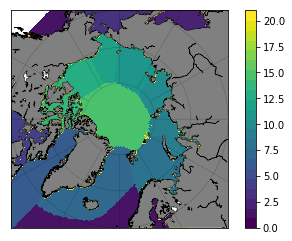

Index(['X', 'Y', 'snow depth in cm', 'Unnamed: 3', 'Unnamed: 4',
       'X and Y = centers of the 100000x100000 m cells', 'Unnamed: 6'],
      dtype='object')
Index(['X', 'Y', 'snow depth in cm', 'Unnamed: 3', 'Unnamed: 4',
       'X and Y = centers of the 100000x100000 m cells', 'Unnamed: 6'],
      dtype='object')
30.3038174629
Beaufort
Index(['X', 'Y', 'snow depth in cm', 'Unnamed: 3', 'Unnamed: 4',
       'X and Y = centers of the 100000x100000 m cells', 'Unnamed: 6'],
      dtype='object')
27.6320551099
Chukchi
Index(['X', 'Y', 'snow depth in cm', 'Unnamed: 3', 'Unnamed: 4',
       'X and Y = centers of the 100000x100000 m cells', 'Unnamed: 6'],
      dtype='object')
30.6078733367
E.Siberian
Index(['X', 'Y', 'snow depth in cm', 'Unnamed: 3', 'Unnamed: 4',
       'X and Y = centers of the 100000x100000 m cells', 'Unnamed: 6'],
      dtype='object')
22.2177315119
Laptev
Index(['X', 'Y', 'snow depth in cm', 'Unnamed: 3', 'Unnamed: 4',
       'X and Y = centers of the 100000x100000 m 

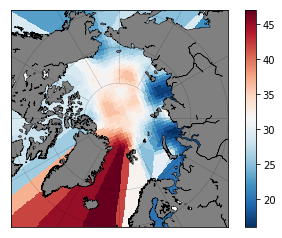

In [110]:
#Average snow depth masked by area

maskfile='/Volumes/n4_cpdata/scb/SNOW_DATA/SNOWMODEL_EASE/GRIDS/arctic_mask.txt'
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
arctic_mask=np.loadtxt(maskfile)
arctic_mask = np.flipud(arctic_mask)
m.drawparallels(np.arange(60,90,10), linewidth = 0.25, linestyle='solid', zorder=8)
m.drawmeridians(np.arange(0.,360.,30.), linewidth = 0.25, zorder=8)
m.drawcoastlines(linewidth=0.5)

m.pcolormesh(x2, y2, arctic_mask, cmap=discrete_cmap(22))
cb = plt.colorbar()
m.fillcontinents(color='grey')
plt.show()

shalina=Read_in_Shalina(x2,y2,'linear')
shalina=np.ma.masked_where(arctic_mask !=8., shalina)

#8. Barents 9. Kara 10. Laptev 11. East Siberian 12. Chuckchi 13. Beaufort 15. Central Arctic




shalina=Read_in_Shalina(x2,y2,'linear')
shalina=np.ma.masked_where(arctic_mask !=13., shalina)
Beaufort=np.nanmean(shalina)
print(np.nanmean(shalina))
print('Beaufort')

shalina=Read_in_Shalina(x2,y2,'linear')
shalina=np.ma.masked_where(arctic_mask !=12., shalina)
Chukchi=np.nanmean(shalina)
print(np.nanmean(shalina))
print('Chukchi')

shalina=Read_in_Shalina(x2,y2,'linear')
shalina=np.ma.masked_where(arctic_mask !=11., shalina)
ESiberian=np.nanmean(shalina)
print(np.nanmean(shalina))
print('E.Siberian')

shalina=Read_in_Shalina(x2,y2,'linear')
shalina=np.ma.masked_where(arctic_mask !=10., shalina)
Laptev=np.nanmean(shalina)
print(np.nanmean(shalina))
print('Laptev')

shalina=Read_in_Shalina(x2,y2,'linear')
shalina=np.ma.masked_where(arctic_mask !=9., shalina)
Kara=np.nanmean(shalina)
print(np.nanmean(shalina))
print('Kara')

shalina=Read_in_Shalina(x2,y2,'linear')
shalina=np.ma.masked_where(arctic_mask !=8., shalina)
Barents=np.nanmean(shalina)
print(np.nanmean(shalina))
print('Barents')

shalina=Read_in_Shalina(x2,y2,'nearest')
plt.clf()
m.drawparallels(np.arange(60,90,10), linewidth = 0.25, linestyle='solid', zorder=8)
m.drawmeridians(np.arange(0.,360.,30.), linewidth = 0.25, zorder=8)
m.drawcoastlines(linewidth=0.5)
m.pcolormesh(x2, y2, shalina, cmap='RdBu_r')
cb = plt.colorbar()
m.fillcontinents(color='grey')
plt.show()
        

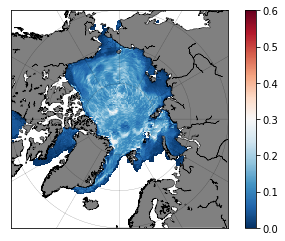

cdo remapbil: SCRIP bilinear weights from lonlat (241x61) to lonlat (361x361) grid
cdo remapbil:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 910cdo remapbil: Processed 14701 values from 1 variable over 1 timestep ( 0.08s )


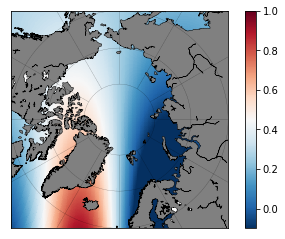

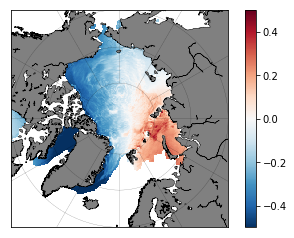

In [10]:
forcing='erai'
variable='snod'
year=1980
snowmodel_filepath='/Volumes/FREECOMHDD/SnowModel/MONTHLY_MEANS/'+forcing+'_'+variable+'_nov_'+str(year)+'.img'
dimT= 1
dimX = 361 #number of rows
dimY = 361 #number of columns
with open(snowmodel_filepath, 'rb') as fr:
    hdr = fr.read(0)#changed from 300 assuming js files have no header
    ice = np.fromfile(fr, dtype=np.float32)#Will's nsidc conc data needed uint32 (or 8, 16 etc)
    ice = ice.reshape(dimT,dimY,dimX)
    ice = np.fliplr(ice)#Flips data l-r (Will's nsidc conc data needed flipud)
    snow_model = ice/100 

snow_model=np.ma.masked_where(snow_model <=0, snow_model) 
    
not_needed, x1, y1=Readin_SnowModel_0916_temp('erai',2010,'snod')#date doesn't matter it's just to get the grid
Replace6931=pyproj.Proj("+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"); #close to polar stereographic but different latitude of origin/ central meridian so adapted above
inProj = Proj(init='epsg:3408')#Replace6931  
outProj = Proj(init='epsg:4326') #lat lon was using 4326
xx, yy = transform(inProj,outProj,x1,y1)
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
x2,y2=m(xx,yy) 
plt.clf()
m.drawparallels(np.arange(60,90,10), linewidth = 0.25, linestyle='solid', zorder=8)
m.drawmeridians(np.arange(0.,360.,30.), linewidth = 0.25, zorder=8)
m.drawcoastlines(linewidth=0.5)
m.pcolormesh(x2, y2, snow_model[0], cmap='RdBu_r',vmin=0, vmax=0.6)
cb = plt.colorbar()
m.fillcontinents(color='grey')
plt.show()

monthname='11'
variablename='Depth'
warren_filepath='/Volumes/FREECOMHDD/MONTHLY_GRIDS/WARREN/'+str(monthname)+'_WarrenSnow'+variablename+'.nc'
! ncatted -a long_name,y,m,c,"latitude"  $warren_filepath  #fixes generic variable z unroecognised error: remapbil needs specific variable names
! ncatted -a long_name,x,m,c,"longitude"  $warren_filepath
! cdo remapbil,myGridDef $warren_filepath temp.nc  
f2 = Dataset('temp.nc', 'r')
snow_warren=f2.variables['z'][:]
plt.clf()
m.drawparallels(np.arange(60,90,10), linewidth = 0.25, linestyle='solid', zorder=8)
m.drawmeridians(np.arange(0.,360.,30.), linewidth = 0.25, zorder=8)
m.drawcoastlines(linewidth=0.5)
m.pcolormesh(x2, y2, snow_warren, cmap='RdBu_r',vmin=-0.1, vmax=1)
cb = plt.colorbar()
m.fillcontinents(color='grey')
plt.show()

plt.clf()
m.drawparallels(np.arange(60,90,10), linewidth = 0.25, linestyle='solid', zorder=8)
m.drawmeridians(np.arange(0.,360.,30.), linewidth = 0.25, zorder=8)
m.drawcoastlines(linewidth=0.5)
m.pcolormesh(x2, y2, (snow_model[0]-snow_warren), cmap='RdBu_r',vmin=-0.5, vmax=0.5)
cb = plt.colorbar()
m.fillcontinents(color='grey')
plt.show()
